# Subset CODEX data into individual regions

The dataset is provided as one .tif file which contains two tissue cores, one from a healthy donor, the other from a donor with acute tonsilitis.

In this notebook we will pre-process the images for subsequent analysis and split the input image into the two individual samples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os

from tifffile import imread, imwrite
from scportrait.processing.images import percentile_normalization
from scportrait.processing.images import downsample_img_padding

from skimage.filters import threshold_otsu, gaussian
from skimage.measure import label, regionprops
from skimage.morphology import dilation
from skimage.transform import resize

/Users/sophia/mambaforge/envs/scportrait/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [10]:
# define paths
output_directory = "../processed_data"
input_directory = "../raw_input_data/example_data/raw"
figures_directory = "../processed_data/figures"
os.makedirs(output_directory, exist_ok=True)
os.makedirs(figures_directory, exist_ok=True)


## Read and process input data

We will perform a percentile normalization on the input images to bring all of the image channels into the same range. By doing this on both tissue cores at the same time we preserve intensity differences between the two tissues.

In [ ]:
# read channel names and bring them into the desired order
# since scportrait expects the channels to be in the order: nucleus, membrane markers, other markers
channel_names = pd.read_csv("f{input_directory}/channelnames.txt", header=None)[0].tolist()
specified_channel_order = ["DAPI", "CD45"]

channel_order = [channel_names.index(channel) for channel in specified_channel_order] + [channel_names.index(channel) for channel in channel_names if channel not in specified_channel_order]
channel_names = [channel_names[channel] for channel in channel_order]

#write channel_names to file for future reference
with open(f"{output_directory}/channelnames.txt", "w") as f:
    for channel in channel_names:
        f.write(f"{channel}\n")

In [7]:
image = imread(f"{input_directory}/tonsil_tma.tif")

# perform percentile normalization to rescale all channels to the same range
lower_quantile = 0.01
upper_quantile = 0.9999

rescaled_image = []
for channel in range(image.shape[0]):
    rescaled_image.append((percentile_normalization(image[channel], lower_quantile, upper_quantile)*np.iinfo(np.uint16).max).astype(np.uint16))
rescaled_image = np.array(rescaled_image)

### Visualize histogram for each measured CODEX channel

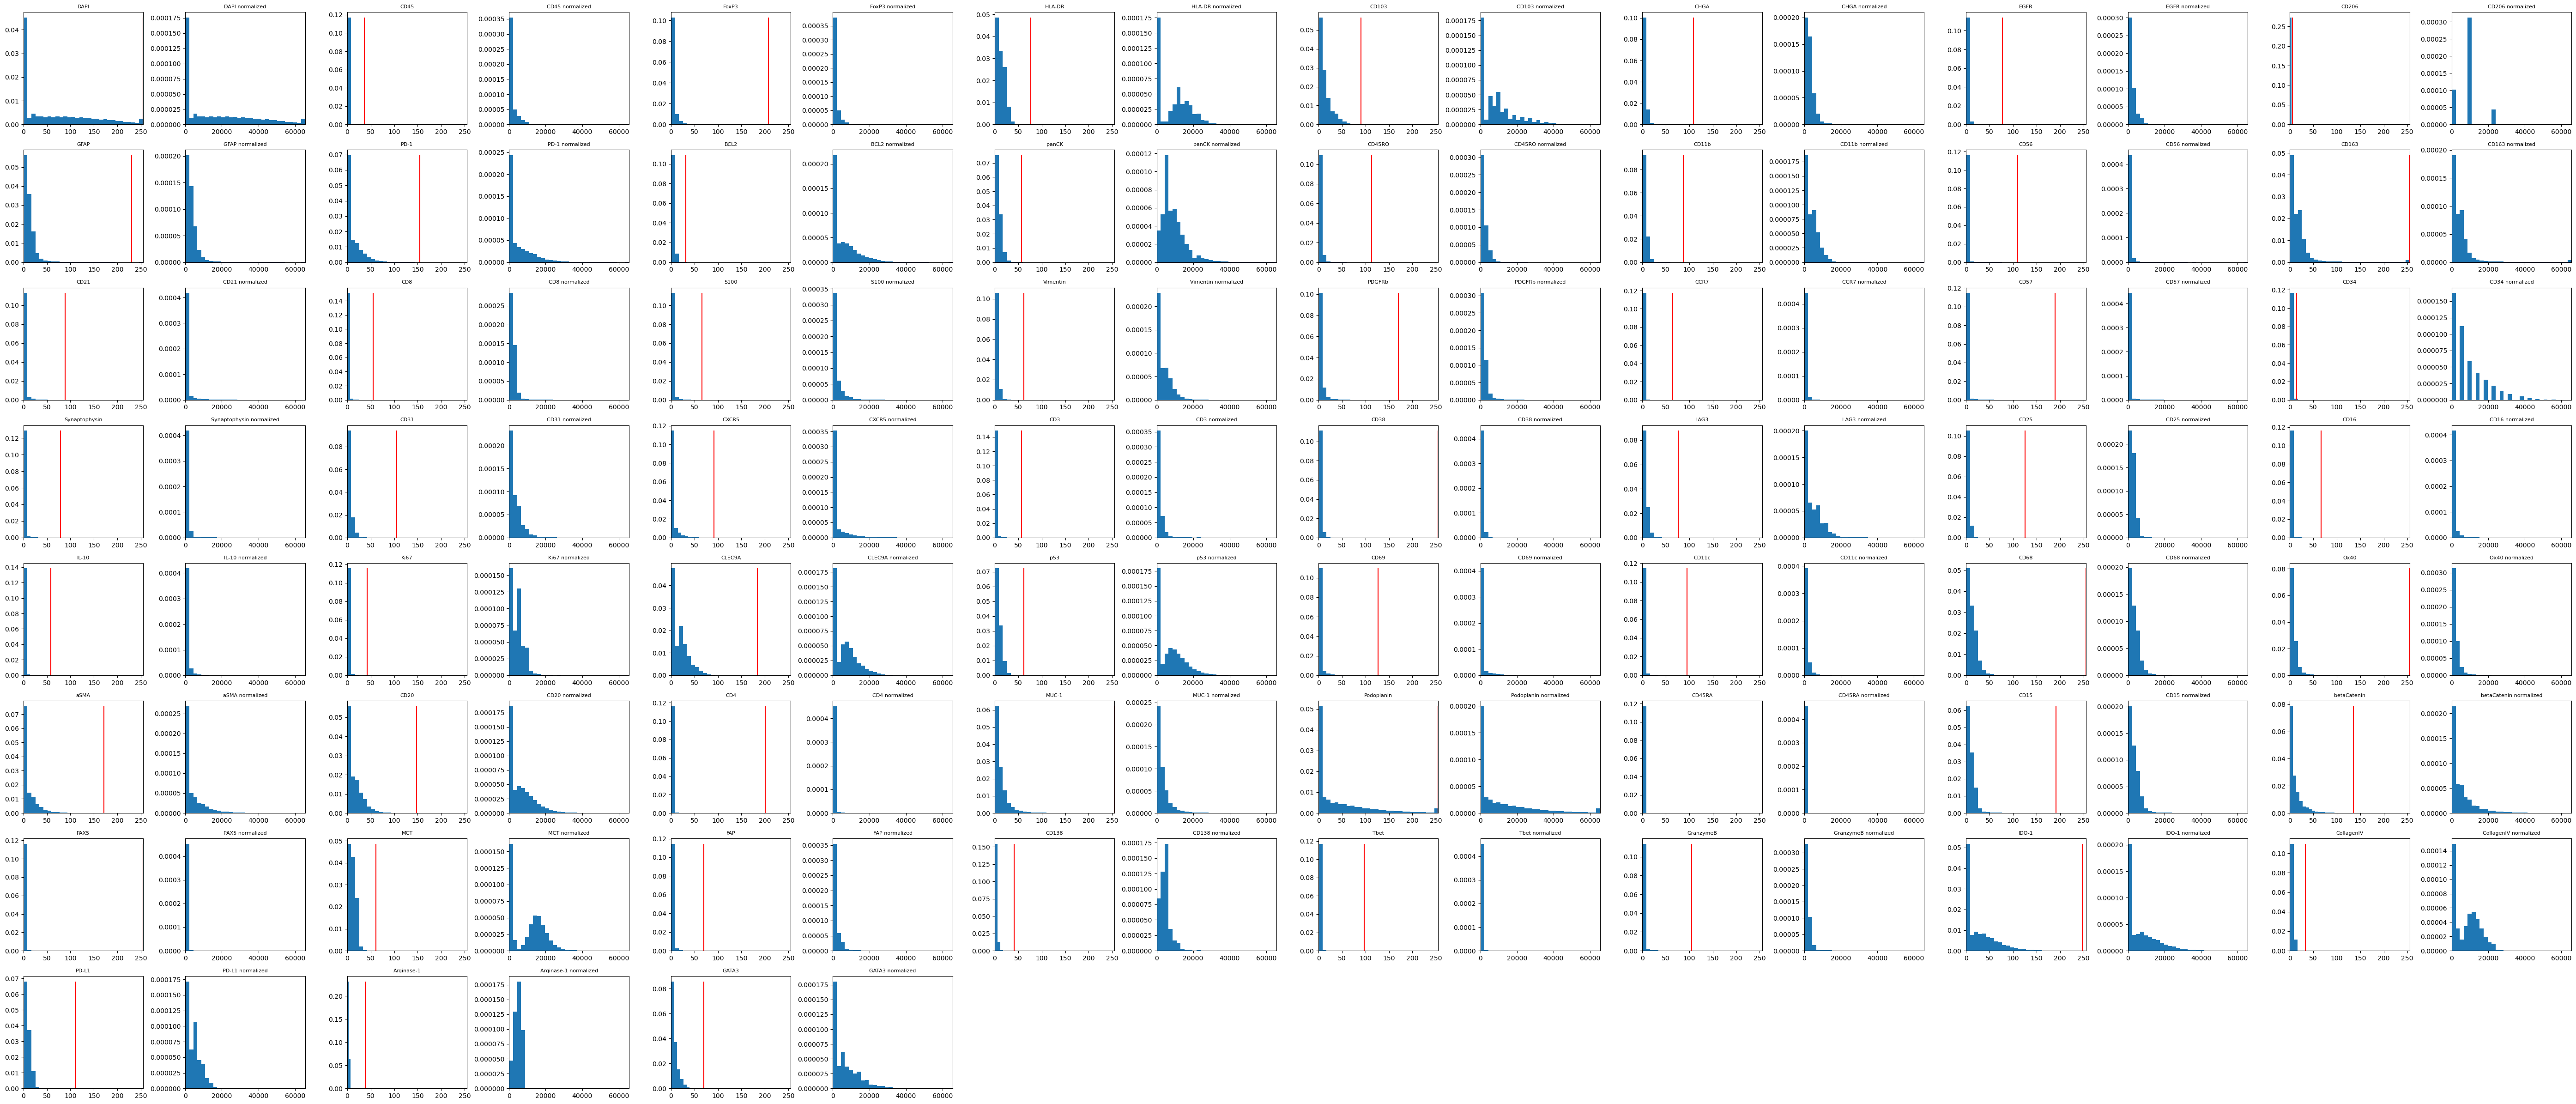

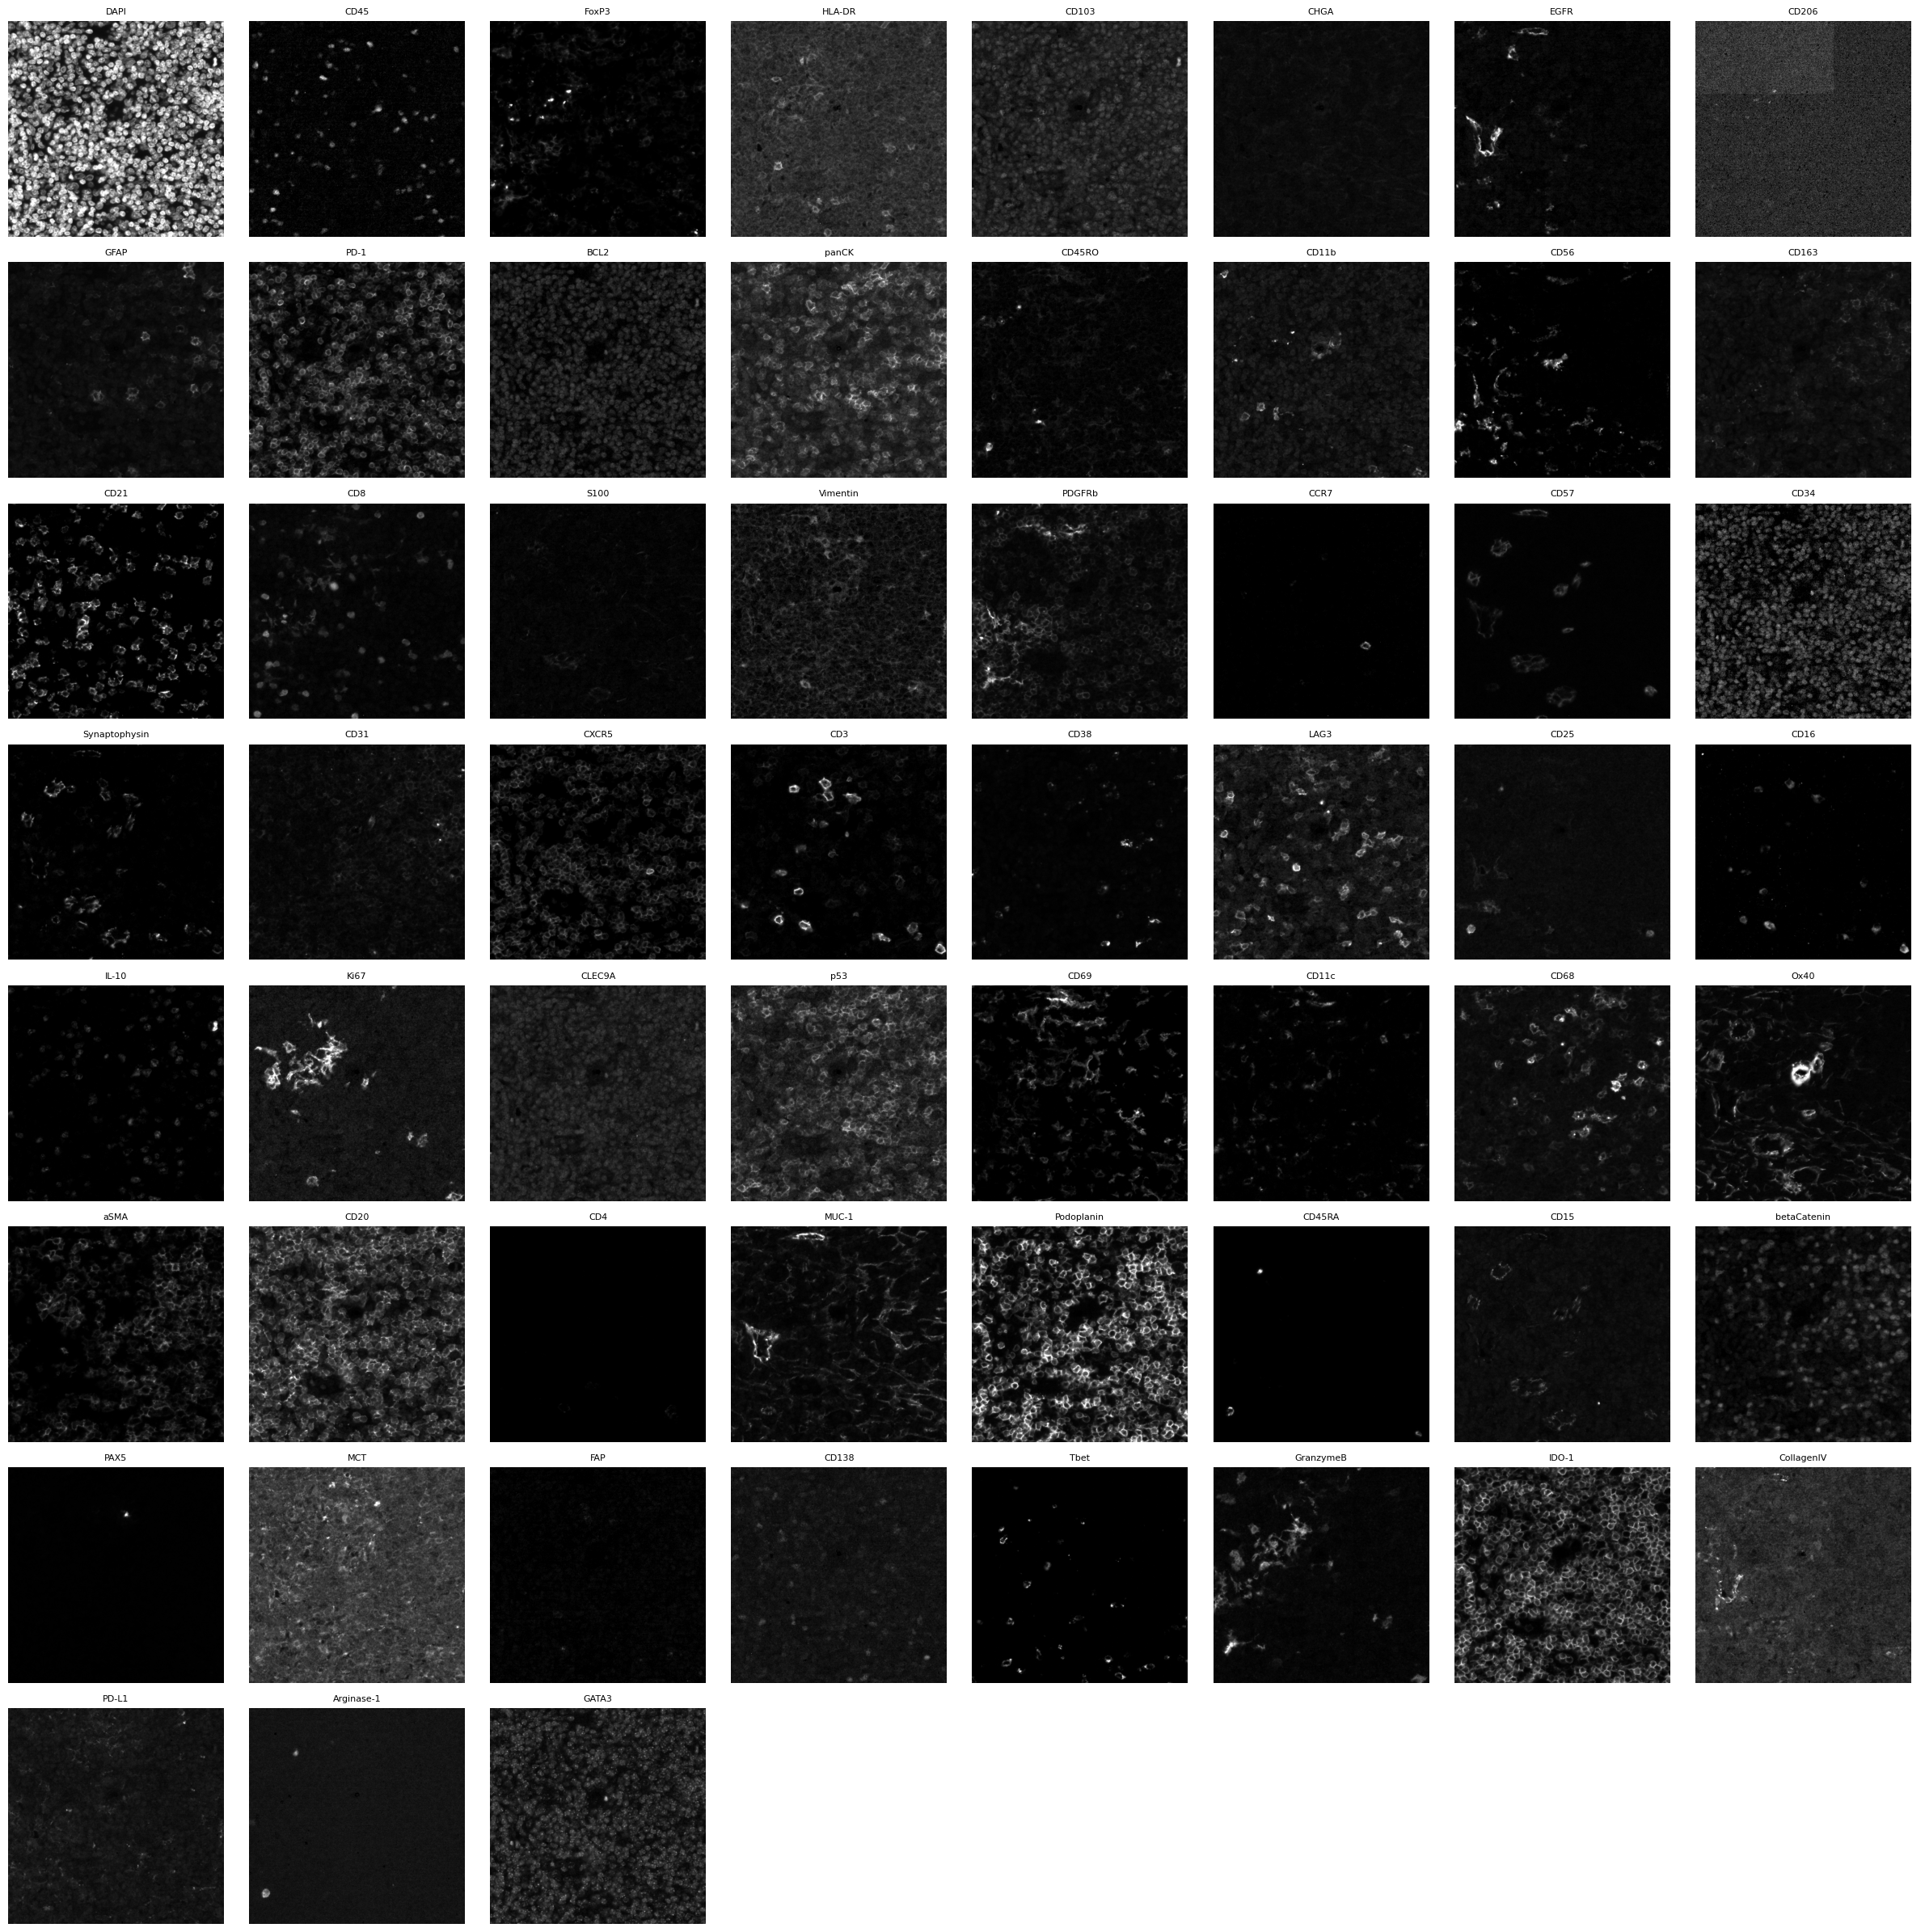

In [11]:
# Define grid size
num_channels = len(channel_names)
grid_rows = int(np.ceil(np.sqrt(num_channels)))  # Adjust based on number of channels
grid_cols = grid_rows * 2  # Each channel has 2 histograms (original + normalized)

# Create a single figure for all histograms
fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 3.5, grid_rows * 3))

axs = axs.flatten()  # Flatten to index easily

for channel in range(num_channels):
    # Original image histogram
    results = axs[channel * 2].hist(image[channel].flatten(), bins=30, density=True)
    axs[channel * 2].vlines(np.quantile(image[channel].ravel(), lower_quantile), 0, results[0].max(), color='red')
    axs[channel * 2].vlines(np.quantile(image[channel].ravel(), upper_quantile), 0, results[0].max(), color='red')
    axs[channel * 2].set_xlim(0, 255)
    axs[channel * 2].set_title(channel_names[channel], fontsize=8)

    # Rescaled image histogram
    results = axs[channel * 2 + 1].hist(rescaled_image[channel].flatten(), bins=30, density=True)
    axs[channel * 2 + 1].set_xlim(0, np.iinfo(np.uint16).max)
    axs[channel * 2 + 1].set_title(f"{channel_names[channel]} normalized", fontsize=8)

# Hide any unused subplots
for i in range(grid_rows * grid_cols):
    if i >= num_channels * 2:
        axs[i].axis("off")

fig.tight_layout()
fig.savefig(f"{figures_directory}/histograms_channel_normalization.pdf")

# Create a grid for cropped image regions
fig, axs = plt.subplots(grid_rows, grid_rows, figsize=(grid_rows * 3, grid_rows * 3))
axs = axs.flatten()  # Flatten the grid for easy indexing

for channel in range(num_channels):
    axs[channel].imshow(rescaled_image[channel, 1000:1500, 1000:1500], 
                        vmin=0, vmax=np.iinfo(np.uint16).max, cmap="gray")
    axs[channel].axis("off")
    axs[channel].set_title(channel_names[channel], fontsize=8)

# Hide any extra subplots
for i in range(len(axs)):
    if i >= num_channels:
        axs[i].axis("off")

fig.tight_layout()
fig.savefig(f"{figures_directory}/input_channels_normalized.pdf")

## Process Images into individual tissue cores

In [12]:
# reorder channels to desired order
image = rescaled_image[channel_order]
channel_names = [channel_names[channel] for channel in channel_order]

Performing image padding to ensure that image is compatible with selected downsample kernel size of 25.
Downsampling image by a factor of 25x25


Text(0.5, 1.0, 'Object Detection')

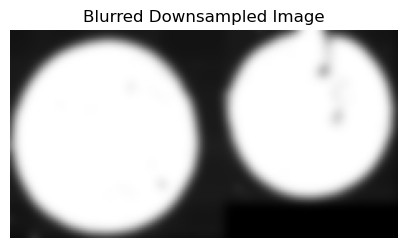

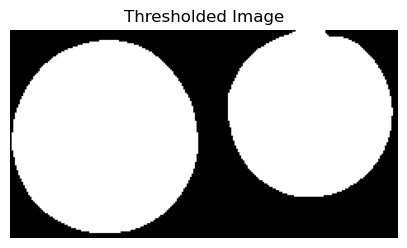

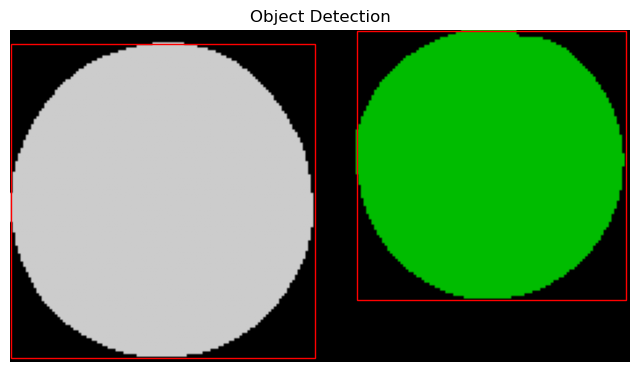

In [25]:
# downsample image to do thresholding to find tissue region 
# only uses the nucleus channel as this has information for most cells
n_px = 25 # number of pixels that will be binned together

downsampled_images = downsample_img_padding(image[0:1], n_px)

# additional percentile normalization  + gaussian blur to improve thresholding
downsampled_images = percentile_normalization(downsampled_images, 0.05, 0.4)
blurred_images = gaussian(downsampled_images, sigma=3)

fig, axs = plt.subplots(1, 1, figsize=(5,5));
axs.imshow(blurred_images[0], cmap="gray");
axs.set_title("Blurred Downsampled Image");
axs.axis("off");

# Perform thresholding with global Otsu on the blurred images
threshold = threshold_otsu(blurred_images)
binary_image = blurred_images > threshold

fig, axs = plt.subplots(1, 1, figsize=(5,5));
axs.imshow(binary_image[0], cmap="gray");
axs.set_title("Thresholded Image");
axs.axis("off");

# Perform object detection
labeled_image = label(binary_image)
dilated_image = dilation(labeled_image)

regions = regionprops(dilated_image[0])

# Plot the labeled image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(dilated_image[0], cmap='nipy_spectral')

#calculate bounding boxes
for region in regions:
    # Extract properties of each object
    minr, minc, maxr, maxc = region.bbox
    width = maxc - minc
    height = maxr - minr

    # Draw bounding box around the object
    rect = patches.Rectangle((minc, minr), width, height, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.axis("off")
ax.set_title('Object Detection')


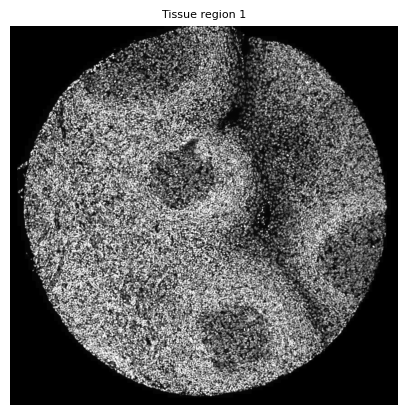

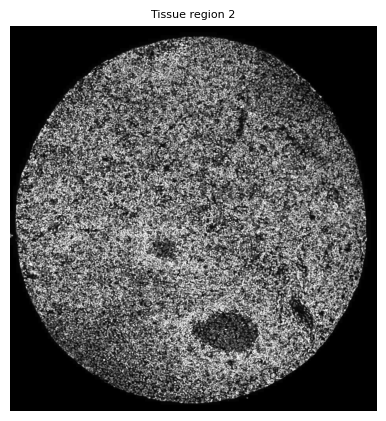

In [26]:
# extract individual tissue regions
ids = set(np.unique(dilated_image)) - set([0])
n_tissue_regions = len(ids)

file_out_directory = f"{output_directory}/codex_tissue_areas"
os.makedirs(file_out_directory, exist_ok=True)

for id in ids:
    region = dilated_image == id
    rescaled_region = resize(region, image.shape, anti_aliasing=False, preserve_range=True)
    rescaled_region = rescaled_region  != 0

    regions = regionprops(rescaled_region[0].astype(np.uint8))

    if len(regions) > 1:
        raise ValueError("Multiple regions detected in the tissue mask.")
    
    # Extract properties of each object
    minr, minc, maxr, maxc = regions[0].bbox
    width = maxc - minc
    height = maxr - minr
    
    # Add padding to the bounding box
    padding = 50
    minr = max(0, minr - padding)
    minc = max(0, minc - padding)
    maxr = min(image.shape[1], maxr + padding)
    maxc = min(image.shape[2], maxc + padding)

    _subset_image = np.where(rescaled_region, image, 0)
    _subset_image = _subset_image[:, minr:maxr, minc:maxc]

    imwrite(f"{file_out_directory}/tissue_region_{id}.tif", _subset_image)

    fig, axs = plt.subplots(1, 1, figsize=(5,5));
    axs.imshow(_subset_image[0], cmap="gray")
    axs.axis("off")
    axs.set_title(f"Tissue region {id}", fontsize=8)

